In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tnmpa import KsatInstance, BeliefPropagation

In [3]:
from quimb.tensor import COPY_tensor
import quimb.tensor as qtn

In [4]:
import random
import numpy as np

In [5]:
# paramter the controls the complexity of the problem, ratio between number of clauses and number of variables
# for alpha > 3.5 BP should start to fail
alpha = 2.0

# number of variables
N = 30

# numer of clauses
M = int(alpha * N)

# K of K-SAT
K = 3

In [6]:
seed = 0
instance = KsatInstance(N, M, K, seed=seed)

In [7]:
ksol_sp = BeliefPropagation(instance)
status = ksol_sp.MP(ksol_sp.envs_tensors, ksol_sp.instance, tol=1e-13)
status["bp_converged"], status["max_distance"]

(True, 8.004708007547379e-14)

In [8]:
ksol_sp.entropy / N

0.4031012104379733

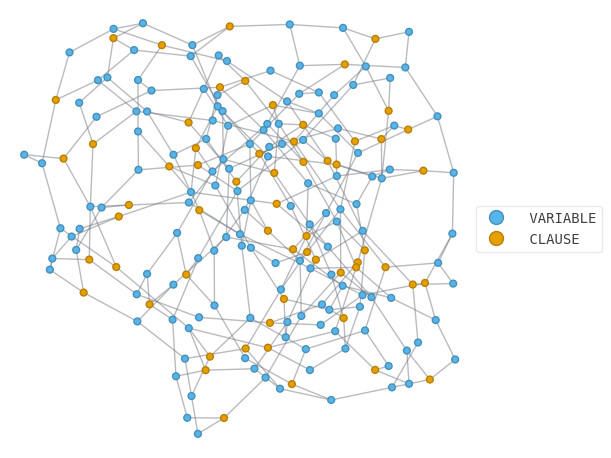

In [12]:
tn = instance.tn(factor_threshold=6)
tn.draw(color=["VARIABLE", "CLAUSE"])

In [13]:
tn.outer_inds()

()

In [14]:
for v in range(N):
    if f"T{v}" not in tn.tag_map.keys():
        continue
    tn, tt = tn.partition_tensors(f"T{v}")
    if len(tn.outer_inds()) > 1:
        new_inds = {i: f"p{v}" for i in tn.outer_inds()}
        tn.reindex(new_inds, inplace=True)
    else:
        tn |= tt

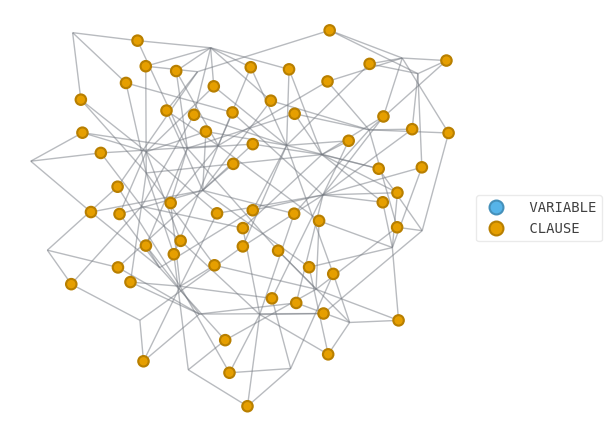

In [15]:
tn.draw(color=["VARIABLE", "CLAUSE"])

In [16]:
distances = []
print(f"var\tL1 norm")
for v in range(N):
    tnv = tn.copy(deep=True)
    if f"p{v}" in tnv.ind_map.keys():
        tids = tnv.ind_map[f"p{v}"].copy()
        for k, tid in enumerate(tids):
            t = tnv.tensor_map[tid]
            t.reindex({f"p{v}":f"p{v}_{k}"}, inplace=True)
    elif f"T{v}" in tnv.tag_map.keys():
        tnv, tt = tnv.partition_tensors(f"T{v}")
    else:
        continue
    
    tnv |= qtn.tensor_core.COPY_mps_tensors(2, list(tnv.outer_inds())+["out"])
    
    for _ in range(1):
        tnv = tnv.full_simplify()
    
    tout = tnv.contract(output_inds=("out",), optimize="greedy")
    mv0 = tout.data[0]
    mv1 = tout.data[1]
    exact = np.array([mv0 / (mv1 + mv0),  mv1 / (mv1 + mv0)])
    
    bp = np.array(ksol_sp.variable_marginal(v))
    distances.append(sum(abs(exact - bp)))
    print(f"{v}\t{sum(abs(exact - bp))}")

var	L1 norm
0	0.013095184019668804
1	0.014155699841682134
2	0.055447789538885406
3	0.05965681430129577
4	0.04597891797717729
5	0.16448529719570915
6	0.4077335284249334
7	0.0926226336710056
8	0.17025306912256516
9	0.16379726282655827
10	0.11345104122583938
11	0.01255203168465946
12	0.005861654973563557
13	0.02331482427100473
14	0.0435307124995819
15	0.0819200351688203
16	0.005501331597935366
17	0.07656704879307091
18	0.09587425277524758
19	0.24033827266907018
20	0.056980753137169216
21	0.17410863539781296
22	0.038167524334697334
23	0.018900842717518573
24	0.13155745736173619
25	0.19580242862238387
26	0.006315600619993145
27	0.06916086391434645
28	0.13878049873915566
29	0.08614225093925076


In [17]:
np.mean(distances)

0.09340180861207795